In [1]:
!nvidia-smi

Tue Nov  3 13:03:42 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.33.01    Driver Version: 440.33.01    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  TITAN RTX           Off  | 00000000:04:00.0 Off |                  N/A |
| 41%   35C    P2    67W / 280W |  12419MiB / 24220MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  TITAN RTX           Off  | 00000000:05:00.0 Off |                  N/A |
| 41%   34C    P8    22W / 280W |  16954MiB / 24220MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

In [2]:
######### IMPORTING NECESSARY MODULES #########
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset, TensorDataset
import sys
import torch.nn as nn
import torch.nn.functional as F
from torch.utils import data

import torch.optim as optim

sys.path.append('/home/ironman/abhishek/Fixtures_Data/architectures/')
sys.path.append('/home/ironman/abhishek/Fixtures_Data/Helper/')
from dataloader import mydataset, create_prime_dict 
from ringloss import RingLoss
# from cutmix_rl_trainer import train, test_classify, eval_classify
from cutmix_rl_trainer_finetune import train, test_classify, eval_classify
from resnet_models import ResNet,Bottleneck
from Load_model import load
from plot_curves import plot_loss, plot_acc

from torch.utils.tensorboard import SummaryWriter

In [3]:
device = torch.device('cuda:6' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:6


**Dataloading Scheme**

In [4]:
trainlist = 'Fixtures_Data_manual_clean_new_training_list_toys.txt'
validlist ='Fixtures_Data_manual_clean_new_validation_list_toys.txt'

In [5]:
prime_dict = create_prime_dict(trainlist)

Number of classes =  3323


In [6]:
#### Train Dataloader #### 
train_dataset = mydataset(trainlist, prime_dict, name='train')          
train_dataloader = data.DataLoader(train_dataset, shuffle= True, batch_size = 256, num_workers=16,pin_memory=True)


#### Validation Dataloader #### 
validation_dataset = mydataset(validlist, prime_dict, name='valid')         
validation_dataloader = data.DataLoader(validation_dataset, shuffle=False, batch_size = 128, num_workers=16,pin_memory=True)

**Model Definition**

In [7]:
# Load Aliproducts model
model = ResNet(Bottleneck, [3, 4, 6, 3], num_classes = 50030)
Alipro_modelpath = '/home/ironman/abhishek/saved_model_checkpoints/AliProducts/NewData_Apro_AA_Cutout_R50'

checkpoint = torch.load(Alipro_modelpath)
model = nn.DataParallel(model,device_ids=[6,7]).to(device)
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [8]:
# Transfer Learning

# for param in model.module.parameters():
#     param.requires_grad = False

fc_inputs = model.module.fc.in_features

model.module.fc = nn.Sequential(
    nn.Linear(fc_inputs, 4096),
    nn.BatchNorm1d(4096),
    nn.ReLU(),
    nn.Linear(4096, 3323)
    
)

model.to(device)

DataParallel(
  (module): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
      

**Hyperparameters**

In [9]:
## Loss Function
criterion = nn.CrossEntropyLoss()

ringloss_block = RingLoss(device,loss_weight=1.0)

# Optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, weight_decay=1e-4, momentum=0.9)

lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size= 40, gamma = 0.1)

# Epochs
num_Epochs = 90

beta=1

cutmix_prob = 1

In [10]:
modelpath = '/home/ironman/abhishek/saved_model_checkpoints/Fixture_Data/Manually_cleaned_Finetune_full_Alipro_R50'

In [11]:
train(model, train_dataloader, validation_dataloader, beta, cutmix_prob, criterion, optimizer, lr_scheduler,
      ringloss_block, modelpath, device, epochs = num_Epochs)

loss 8.08052716255188
loss 15.920410809516907
loss 23.497803583145142
loss 30.854775733947754
loss 37.93848604679108
loss 44.82724024295807
loss 51.47983014583588
loss 57.93654422283173
loss 64.18351231575012
loss 70.20425318717956
loss 76.0966987657547
loss 81.80420802593231
Epoch:  1
training loss =  6.753814230974628
Validation Loss: 3.8028	Top 1 Validation Accuracy: 0.4920	 Top 5 Validation Accuracy: 0.6212
loss 5.434183826446533
loss 10.672455492019653
loss 15.814069247245788
loss 20.903736436367033
loss 25.875589847564697
loss 30.66102529525757
loss 35.377450861930846
loss 40.10860330343247
loss 44.66744613885879
loss 49.145861024856565
loss 53.578160808086395
loss 57.82664765357971
Epoch:  2
training loss =  4.789372237184413
Validation Loss: 2.4126	Top 1 Validation Accuracy: 0.6609	 Top 5 Validation Accuracy: 0.7747
loss 4.240662200450897
loss 8.326120009422302
loss 12.540733065605163
loss 16.507731237411498
loss 20.517527997493744
loss 24.493798315525055
loss 28.46161967754364

Validation Loss: 0.7038	Top 1 Validation Accuracy: 0.8606	 Top 5 Validation Accuracy: 0.9522
loss 1.8419102233648301
loss 3.6954191017150877
loss 5.548306069374084
loss 7.365108538269997
loss 9.152405455112458
loss 10.98137202501297
loss 12.829361285567284
loss 14.679957154989243
loss 16.501762316823005
loss 18.352561622858047
loss 20.168486276268958
loss 22.000318446755408
Epoch:  21
training loss =  1.8326795312559812
Validation Loss: 0.6837	Top 1 Validation Accuracy: 0.8616	 Top 5 Validation Accuracy: 0.9533
loss 1.7466176575422288
loss 3.5447945410013197
loss 5.3423509567976
loss 7.0889362233877184
loss 8.908890261650086
loss 10.60770549416542
loss 12.477152807116509
loss 14.248184988498688
loss 16.00357771039009
loss 17.754196506142616
loss 19.4751269954443
loss 21.26910708606243
Epoch:  22
training loss =  1.774519572749522
Validation Loss: 0.6789	Top 1 Validation Accuracy: 0.8626	 Top 5 Validation Accuracy: 0.9544
loss 1.739382919073105
loss 3.574103459119797
loss 5.376747399568

loss 10.953770253956318
loss 12.5576059243083
loss 14.10833248347044
loss 15.645536946356296
loss 17.182009529173374
loss 18.790918537676333
Epoch:  40
training loss =  1.5638980147727481
Validation Loss: 0.5997	Top 1 Validation Accuracy: 0.8734	 Top 5 Validation Accuracy: 0.9623
loss 1.528625116944313
loss 3.0596725046634674
loss 4.5649344563484195
loss 6.082031109333038
loss 7.592375694513321
loss 9.117736817002296
loss 10.672435339689255
loss 12.19060963690281
loss 13.703729545474053
loss 15.233211914300918
loss 16.796872028708457
loss 18.329961894750596
Epoch:  41
training loss =  1.527049540484686
Validation Loss: 0.5904	Top 1 Validation Accuracy: 0.8743	 Top 5 Validation Accuracy: 0.9633
loss 1.5473680895566941
loss 3.074399883151054
loss 4.628928417265415
loss 6.149676126539707
loss 7.683815356194973
loss 9.253270466029644
loss 10.780853359997273
loss 12.314068123996257
loss 13.866071933805943
loss 15.362636514604091
loss 16.860295301377775
loss 18.42071727871895
Epoch:  42
trai

loss 6.026485195755958
loss 7.549790277481079
loss 9.042164558768272
loss 10.544067777395249
loss 12.040179445743561
loss 13.544255329072476
loss 15.03938252478838
loss 16.507188124954702
loss 18.03807659059763
Epoch:  60
training loss =  1.5069456547734108
Validation Loss: 0.5820	Top 1 Validation Accuracy: 0.8751	 Top 5 Validation Accuracy: 0.9639
loss 1.5051961666345597
loss 2.9880034911632536
loss 4.443975931406021
loss 5.91137761592865
loss 7.363396583199501
loss 8.88456578373909
loss 10.3900782507658
loss 11.91344418466091
loss 13.451528014540672
loss 14.885523536503316
loss 16.398969991505147
loss 17.939331077039242
Epoch:  61
training loss =  1.496898286456557
Validation Loss: 0.5800	Top 1 Validation Accuracy: 0.8758	 Top 5 Validation Accuracy: 0.9646
loss 1.4285794723033904
loss 2.9221457123756407
loss 4.475541702508926
loss 5.951929237246514
loss 7.4372284501791
loss 8.904916616082192
loss 10.394162921607494
loss 11.951738150417805
loss 13.420025306642055
loss 14.9188856908679

Epoch:  79
training loss =  1.485072235454692
Validation Loss: 0.5766	Top 1 Validation Accuracy: 0.8757	 Top 5 Validation Accuracy: 0.9651
loss 1.451449978351593
loss 2.929717579483986
loss 4.41514633089304
loss 5.875318399071693
loss 7.37968994140625
loss 8.88456448495388
loss 10.378071753978729
loss 11.836688796281814
loss 13.315667746067048
loss 14.850383876264095
loss 16.320168521106243
loss 17.762616394460203
Epoch:  80
training loss =  1.479842273097656
Validation Loss: 0.5767	Top 1 Validation Accuracy: 0.8761	 Top 5 Validation Accuracy: 0.9652
loss 1.4859594222903252
loss 2.93710758715868
loss 4.4058133736252785
loss 5.876860254108906
loss 7.379296636283398
loss 8.821642471849918
loss 10.247157550752164
loss 11.699863066971302
loss 13.119843085706234
loss 14.595164356529713
loss 16.045089120566846
loss 17.564711031019687
Epoch:  81
training loss =  1.4667520905605047
Validation Loss: 0.5741	Top 1 Validation Accuracy: 0.8765	 Top 5 Validation Accuracy: 0.9650
loss 1.5238875895738

In [10]:
#### Load saved model from checkpoint  #####
model, optimizer, lr_scheduler, train_loss, v_loss, v_acc, epoch = load(modelpath, model, optimizer, lr_scheduler)


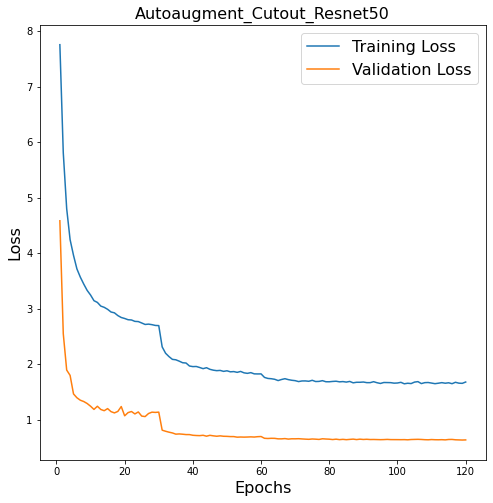

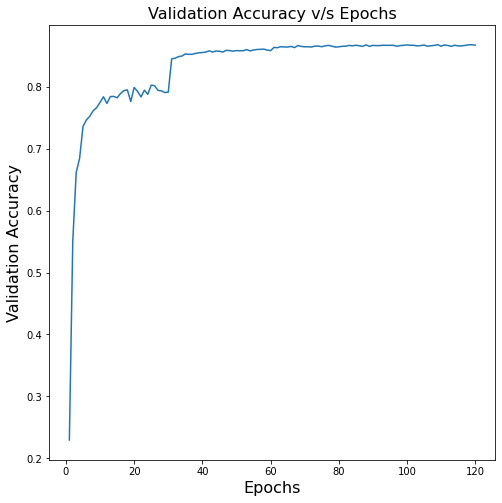

In [11]:
#### Plot Loss Curves ####
plot_loss(epoch, train_loss, v_loss, title = 'Autoaugment_Cutout_Resnet50')
plot_acc(epoch, v_acc)

In [20]:
t_loss,top1_t_acc, top5_t_acc =test_classify(model, train_dataloader, criterion, device)
print('Training Loss: {:.4f}\tTop 1 Training Accuracy: {:.4f}\t Top 5 Training Accuracy: {:.4f}'.format(t_loss, top1_t_acc, top5_t_acc))

Training Loss: 0.4860	Top 1 Training Accuracy: 0.8849	 Top 5 Training Accuracy: 0.9747


In [12]:
v_loss, top1_acc, accuracy_dict= eval_classify(model, validation_dataloader, criterion, device)
print('Validation Loss: {:.4f}\tTop 1 Validation Accuracy: {:.4f}\nAccuracy:{}\t'.format(v_loss, top1_acc, accuracy_dict))

Validation Loss: 0.5753	Top 1 Validation Accuracy: 0.8763
Accuracy:defaultdict(<class 'int'>, {'Top 1 Accuracy': 87.63281913180927, 'Top 5 Accuracy': 96.53133507010509, 'Top 10 Accuracy': 97.62901384538829, 'Top 20 Accuracy': 98.34909112197407, 'Top 30 Accuracy': 98.67693118285865, 'Top 50 Accuracy': 99.01062553054474, 'Top 100 Accuracy': 99.3209027310248})	
